In [19]:
from script.condition import activity, boundary_condition

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm
import os
import joblib

from matplotlib import cm
from ast import literal_eval
from sklearn.preprocessing import MinMaxScaler, StandardScaler

cn_dict = joblib.load('./data/CN_dict.pkl')
scaler_dict = joblib.load('./data/scaler_dict.pkl') # 0: formate, 1: CO, 2: C1, 3: H2

# Selectivity by Applied Potential

## Calculate Selectivity

In [25]:
# metal_lst = ['Ag', 'Al', 'As', 'Au', 'Co', 'Cr', 'Cu', 'Fe', 'Ga', 'Ge', 'In', 
#              'Ir', 'Mn', 'Mo', 'Ni', 'Os', 'Pb', 'Pd', 'Pt', 'Re', 'Rh', 'Ru', 
#              'Sb', 'Se', 'Si', 'Sn', 'Ti', 'V', 'W', 'Zn']


products = ['formate','co','c1','h2'] # expected CO2RR products
data_path = '/home/ahrehd0506/git/DSTAR_mine/subs/co_fp_for_co/'
csv = 'Cu_Ga.csv' # metal combination 

metal_A, metal_B = csv.split('.')[0].split('_')
raw_df = pd.read_csv(data_path + csv, index_col=0)
raw_df.drop_duplicates(['FNN','Same','Sub'], inplace = True)

# extract composition of active motif
composition = []
for i, v in raw_df.iterrows():
    fnn = literal_eval(v['FNN'])
    same = literal_eval(v['Same'])
    sub = literal_eval(v['Sub'])
    
    A, B = 0, 0
    
    for site in [fnn,same,sub]:
        if metal_A in site.keys():
            A += site[metal_A]
        if metal_B in site.keys():
            B += site[metal_B]
    
    comp = A/(A+B)    
    composition.append(round(comp*20,0)/2)
raw_df['composition'] = composition
    
# extract coordination number
CNs = []
for id_ in raw_df['name']:
    CN = cn_dict[id_]
    CNs.append(CN)
raw_df['cn'] = CNs


# You can masking the data with criteria of coordination number or composition of active motif
df = raw_df.copy()
df = df[df['cn'] > 0]          # coordination number masking
df = df[df['composition'] > 0] # composition masking


fnn_lst = [literal_eval(i) for i in df['FNN']]
co_lst = df['co'].to_numpy()
oh_lst = df['oh'].to_numpy()
h_lst = df['h'].to_numpy()

eU_lst = [-1.65,-1.55, -1.45, -1.35, -1.25, -1.15, -1.05, -0.95, -0.85, -0.75, -0.65, -0.55]
total = len(df)
eU_dict = { }

for eU in eU_lst:
    density = np.zeros(4)
    for x,y,z in zip(co_lst, h_lst, oh_lst):
        product = boundary_condition(x,y,z,eU) # determine product by boundary conditon
        barrier = activity(x,y,z,eU,product)  # calculate thermodynamic barrier

        if barrier <= 0: # count active motifs with no uphill at the applied potential
            density[products.index(product)] += 1 

    density /= total # calculate density 
    for idx,dens in enumerate(density): # Normalizng
                density[idx] = scaler_dict[eU][idx].transform(np.array([dens]).reshape(-1,1))[0][0]
    
    eU_dict[eU] = density

## Selectivity plot

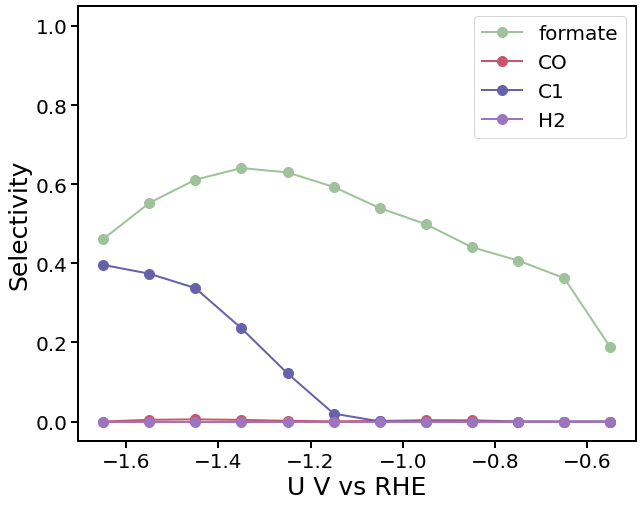

In [26]:
blue = '#6661AB'
red = '#C8566B'
purple = '#9D75BF'
green = '#9EC299'

formate = [eU_dict[eU][0] for eU in eU_lst]
co = [eU_dict[eU][1] for eU in eU_lst]
c1 = [eU_dict[eU][2] for eU in eU_lst]
h2 = [eU_dict[eU][3] for eU in eU_lst]

fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(eU_lst, formate, lw = 2, marker='o',markersize=10,color=green, label='formate')
ax.plot(eU_lst, co, lw = 2, marker='o',markersize=10,color=red, label='CO')
ax.plot(eU_lst, c1, lw = 2, marker='o',markersize=10,color=blue, label='C1')
ax.plot(eU_lst, h2, lw = 2, marker='o',markersize=10,color=purple, label='H2')
ax.legend(fontsize=20)
ax.set_ylim([-0.05,1.05])
ax.set_xlim(-1.705, -0.495)
[ax.spines[i].set_linewidth(2) for i in ax.spines.keys()]
ax.tick_params(width = 2, size = 7, labelsize = 20)
ax.set_ylabel('Selectivity',fontsize=25)
ax.set_xlabel('U V vs RHE',fontsize=25)

plt.savefig('./figure/Plot.svg')

# Selectivity by Composition & CN

## Composition

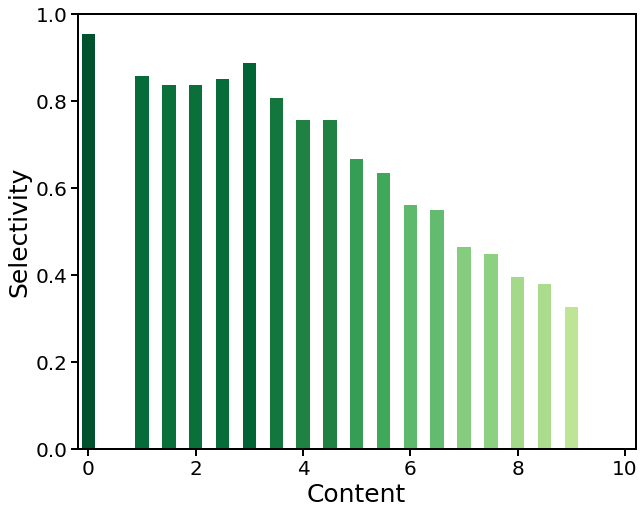

In [30]:
eU = -1.4 # applied potential
df = raw_df.copy()

compos_set = [i for i in set(composition)]
compos_dict = dict()

for compos in compos_set:
    masked_df = df[df['composition'] == compos] # masking DataFrame with specific composition

    co_lst = masked_df['co'].to_numpy()
    oh_lst = masked_df['oh'].to_numpy()
    h_lst = masked_df['h'].to_numpy()
    total = len(masked_df)
    
    if len(masked_df) > len(raw_df)*0.01: # masked data should be larger than 1% of total data 
        density = np.zeros(4)
        
        for x,y,z in zip(co_lst, h_lst, oh_lst):
            product = boundary_condition(x,y,z,eU) # determine product by boundary conditon
            barrier = activity(x,y,z,eU,product)  # calculate thermodynamic barrier

            if barrier <= 0: # count active motifs with no uphill at the applied potential
                density[products.index(product)] += 1 

        density /= total # calculate density 
        for idx,dens in enumerate(density): # Normalizng
                    density[idx] = scaler_dict[eU][idx].transform(np.array([dens]).reshape(-1,1))[0][0]

        compos_dict[compos] = density

        
fig, ax = plt.subplots(1,1,figsize=[10,8])
x = list(compos_dict.keys())
y = [i[0] for i in compos_dict.values()] # 0: formate, 1: CO, 2: C1, 3: H2

norm = mpl.colors.Normalize(vmin=0,vmax=1)
colors = [cm.YlGn(norm(i)) for i in y]

ax.bar(x,y, width=0.25, color =colors)
ax.set_xlim([-0.2,10.2])
ax.set_ylim([0,1])
[ax.spines[i].set_linewidth(2) for i in ax.spines.keys()]
ax.tick_params(width = 2, size = 7, labelsize = 20)
ax.set_ylabel('Selectivity',fontsize=25)
ax.set_xlabel('Content',fontsize=25)
plt.savefig('./figure/Composition.svg')

## CN

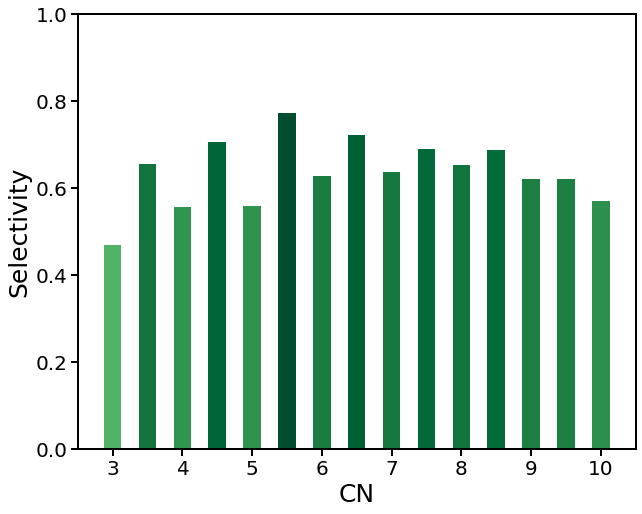

In [31]:
eU = -1.4 # applied potential
df = raw_df.copy()

cn_set = [i for i in set(CNs)]
cn_dict = dict()

for cn in cn_set:
    masked_df = df[df['cn'] == cn] # masking DataFrame with specific CN

    co_lst = masked_df['co'].to_numpy()
    oh_lst = masked_df['oh'].to_numpy()
    h_lst = masked_df['h'].to_numpy()
    total = len(masked_df)
    
    if len(masked_df) > len(raw_df)*0.01: # masked data should be larger than 1% of total data 
        density = np.zeros(4)
        
        for x,y,z in zip(co_lst, h_lst, oh_lst):
            product = boundary_condition(x,y,z,eU) # determine product by boundary conditon
            barrier = activity(x,y,z,eU,product)  # calculate thermodynamic barrier

            if barrier <= 0: # count active motifs with no uphill at the applied potential
                density[products.index(product)] += 1 

        density /= total # calculate density 
        for idx,dens in enumerate(density): # Normalizng
                    density[idx] = scaler_dict[eU][idx].transform(np.array([dens]).reshape(-1,1))[0][0]

        cn_dict[cn] = density

        
fig, ax = plt.subplots(1,1,figsize=[10,8])
x = list(cn_dict.keys())
y = [i[0] for i in cn_dict.values()] # 0: formate, 1: CO, 2: C1, 3: H2

norm = mpl.colors.Normalize(vmin=0,vmax=0.8)
colors = [cm.YlGn(norm(i)) for i in y]

ax.bar(x,y, width=0.25, color =colors)
ax.set_xlim([2.5,10.5])
ax.set_ylim([0,1])
[ax.spines[i].set_linewidth(2) for i in ax.spines.keys()]
ax.tick_params(width = 2, size = 7, labelsize = 20)
ax.set_ylabel('Selectivity',fontsize=25)
ax.set_xlabel('CN',fontsize=25)
plt.savefig('./figure/CN.svg')